In [1]:
#| default_exp activations

## Activation stats

In order to understand a model behaviour when training it is helpful to understand how the values of the activations vary through the model and as training progresses.  

In [1]:
#|export
from __future__ import annotations
import random,math,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial

from torch import tensor,nn,optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset

from miniai.datasets import *
from miniai.learner import *

In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)

In [4]:
#|export
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [5]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

  0%|          | 0/2 [00:00<?, ?it/s]

## Baseline 
To create a baseline a simple conv with a final flatten layer will be created

In [6]:
def conv(ni, nf, ks=3, act=True):

    res = nn.Conv2d(ni, nf, ks, stride=2, padding=ks//2)
    if act==True:
        res = nn.Sequential(res, nn.ReLU())
    return res

# Create a basic CNN classifier
def cnn_layers():
    return [
        conv(1, 8, ks=5), # 14*14
        conv(8, 16), #7*7
        conv(16, 32), #4*4
        conv(32, 64), #2*2
        conv(64, 10, act=False), #1*1
        nn.Flatten()
    ]

In [7]:
from torcheval.metrics import MulticlassAccuracy

In [8]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [9]:
def fit(model, epochs, xtra_cbs=None):
    learn = Learner(model, dls=dls, loss_func=F.cross_entropy,  lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

accuracy,loss,epoch,train
0.242,2.111,0,True
0.376,2.125,0,False


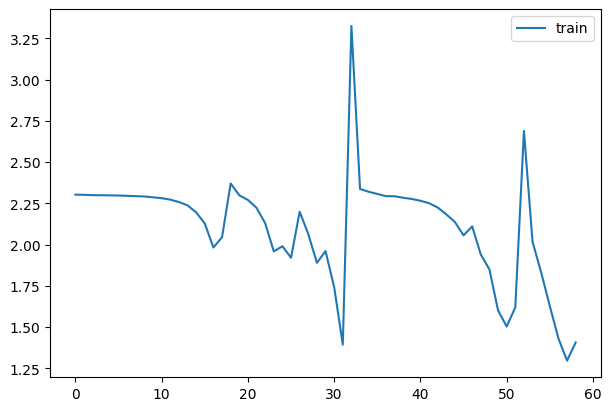

In [10]:
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()), epochs=1)

## Hooks

Hooks are necessary to extract internal values from the NN, which can be useful to understand how a network is behaving, as well as using internal values for control etc.

To develop understanding of hooks a class will be generated that allows us to store and then recall / process mean and standard deviation of layers in a model as it trains

In [11]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        # Create an empty list for each layer to save means
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
        
    def __call__(self, x):
        """ pass the input through each layer, saving the activation stats at each stage
        """
        for i, l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(to_cpu(x).mean())
            self.act_stds[i].append(to_cpu(x).std())
        return x
    
    #def __iter__(self): 
    #    print(f'calling iter')
    #    return iter(self.layers)

accuracy,loss,epoch,train
0.242,2.111,0,True
0.376,2.125,0,False


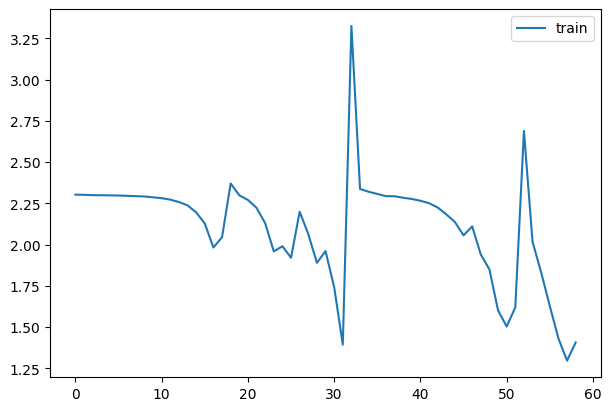

In [12]:
set_seed(1)
model = SequentialModel(*cnn_layers())
learn = fit(model, epochs=1)

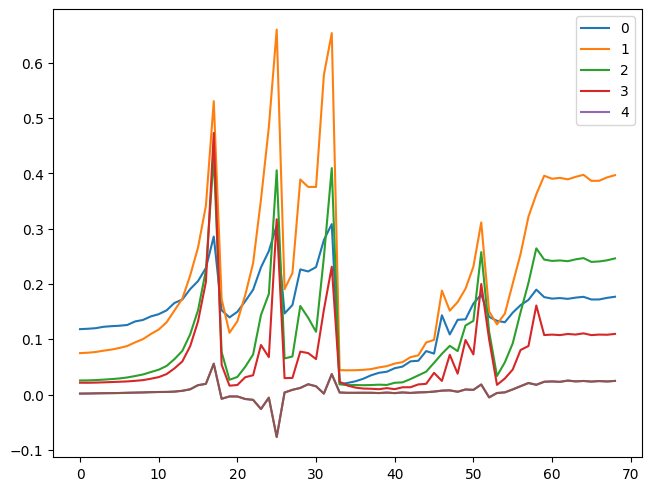

In [13]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

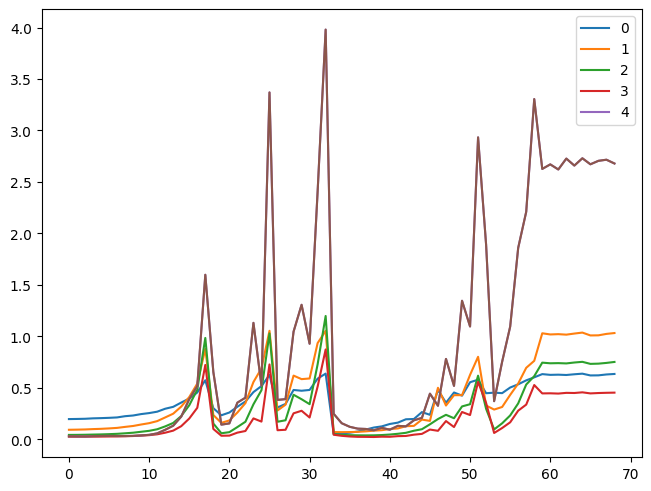

In [14]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));

Whilst this works it is cumbersome and in with larger models it might not be desirable to catch the values of every layer, or it might be required to save all of the activations rather than the stats etc.  The Pytorch Hooks provide a flexible way to achieve this

## Pytorch Hooks 

Hooks are PyTorch object you can add to any nn.Module. A hook will be called when a layer, it is registered to, is executed during the forward pass (forward hook) or the backward pass (backward hook). Hooks don't require us to rewrite the model.

In [15]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

A hook is attached to a layer, and needs to have a function that takes three arguments: module, input, output. Here we store the mean and std of the output in the correct position of our list.

In [16]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

In [17]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(to_cpu(outp).mean())
    act_stds[i].append(to_cpu(outp).std())

[Link to pytorch forward hook docs](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=register_forward_hook#torch.nn.Module.register_forward_hook)

In [18]:
# Register the hooks
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

accuracy,loss,epoch,train
0.242,2.111,0,True
0.376,2.125,0,False


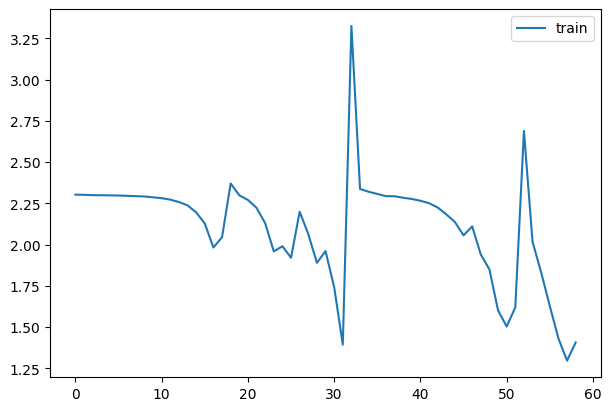

In [19]:
fit(model, epochs=1)

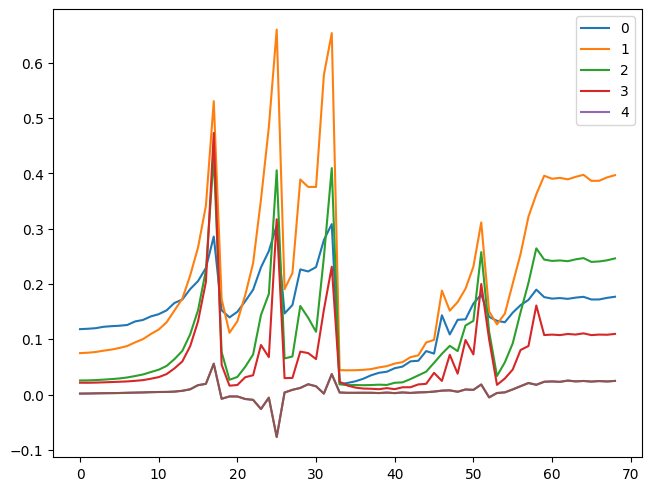

In [20]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

### Hook Class

It is very important to both assign and then remove hooks otherwise it is likely to cause memory problems

In [21]:
#| export
class Hook():
    def __init__(self, m, func): 
        self.hook = m.register_forward_hook(partial(func, self))
    def remove(self):
        self.hook.remove()
    def __del__(self):
        self.remove()

In [22]:
def append_stats(hook, mod, inp, outp):
    # Initialize hook by adding stats attribute
    if not hasattr(hook, 'stats'):
        hook.stats = ([], [])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

In [23]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [24]:
hooks = [Hook(l, append_stats) for l in model[:5].children()]

accuracy,loss,epoch,train
0.242,2.111,0,True
0.376,2.125,0,False


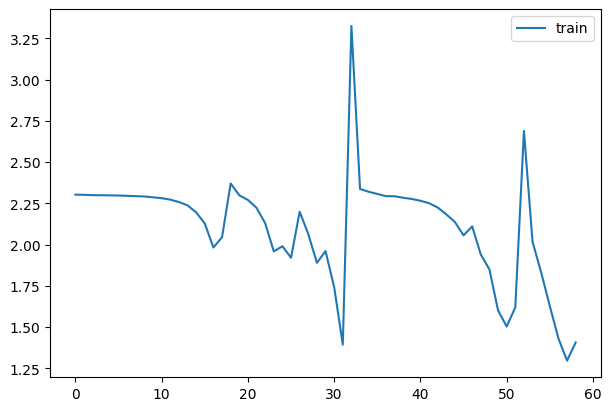

In [25]:
learn = fit(model, epochs=1)

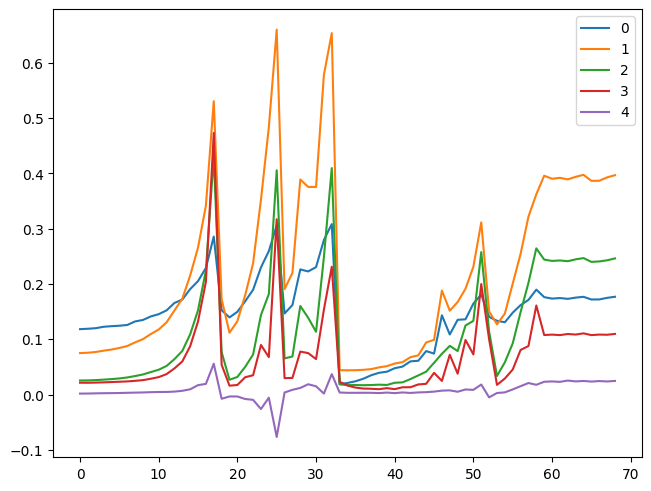

In [26]:
# Plot the activations stats and remove the hooks
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5));

In [27]:
[child for child in iter(model[:5].children())]

[Sequential(
   (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
   (1): ReLU()
 ),
 Sequential(
   (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ),
 Sequential(
   (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ),
 Sequential(
   (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ),
 Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))]

### A Hooks Class
It is possible to use a context manager to ensure that all hooks are removed when no longer needed

In [28]:
class DummyCtxMgr:
    def __enter__(self, *args):
        print("let's go!")
        return self
    def __exit__ (self, *args): print("all done!")
    def hello(self): print("hello.")

In [29]:
with DummyCtxMgr() as dcm:
    dcm.hello()

let's go!
hello.
all done!


In [30]:
class DummyList(list):
    def __delitem__(self, i):
        print(f"Say bye to item {i}")
        super().__delitem__(i)

In [31]:
dml = DummyList([1,3,2])
dml

[1, 3, 2]

In [32]:
del(dml[2])

Say bye to item 2


In [33]:
dml

[1, 3]

In [34]:
#|export
class Hooks(list):
    """ Class to act as a container and context manager for a set of hooks and to ensure that they are 
    all removed at the end.  For the context manager the very least that is needed is an __enter__ and 
    and __exit__.
    
    The __del__ method is called to delete the class should that be required
    
    """
    def __init__(self, mdl, func):
        # Initialize a hook for each layer and assign to a list
        super().__init__([Hook(l, func) for l in mdl])
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
    def __del__(self):
        # triggered to delete the class.  This calls the remove method to remove all of the hooks
        self.remove()
    def __delitem__(self, i):
        # delete a specific hook from the model
        self[i].remove()
        # remove the hook from the list
        super().__delitem__(i)
    def remove(self): 
        for h in self: h.remove()
        

In [35]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

accuracy,loss,epoch,train
0.242,2.111,0,True
0.376,2.125,0,False


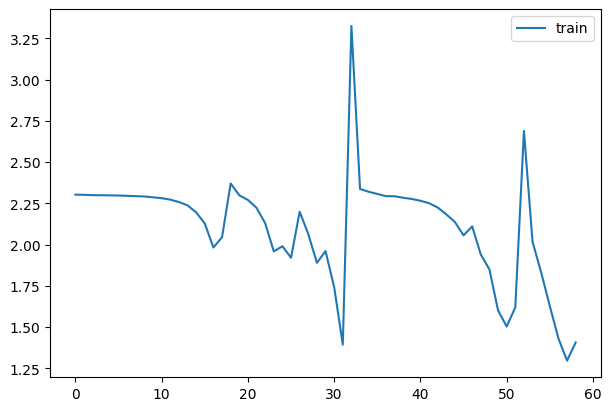

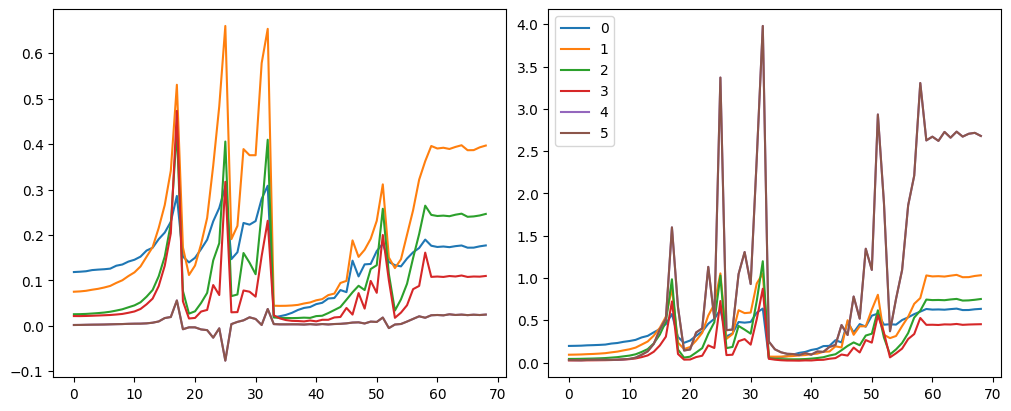

In [36]:
with Hooks(model, append_stats) as hooks:
    fit(model, epochs=1)
    fig, axs = plt.subplots(1,2, figsize=(10, 4))
    for h in hooks:
        for i in 0, 1: axs[i].plot(h.stats[i])
plt.legend(range(6))

## Hooks Callback

Now that there is a class to manage the hooks a more flexible way of implementing it is needed. In particular it is necessary to be able to filter the list of layers to allow selection of specific types or cases, and to only apply the hook function during training

In [3]:
#|export
class HooksCallback(Callback):
    def __init__(self, hookfunc, module_filter=fc.noop, on_train=True, on_valid=False, 
                mods=None):
        """ mods should be a set of layers to which hooks should be applied.  If mods
        is supplied then module_filter is not used.
        """
        fc.store_attr()
        super().__init__()
    
    def before_fit(self, learn): 
        if self.mods:
            mods = self.mods
        else:
            # get list of filtered layers
            mods = fc.filter_ex(learn.model.modules(), self.module_filter)
        # create hooks
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))
    
    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or \
            (self.on_valid and not learn.training): self.hookfunc(*args, **kwargs)
    
    def after_fit(self, learn): self.hooks.remove()
    
    def __iter__(self): return iter(self.hooks)
    def __len__(self): return len(self.hooks)
    

In [97]:
fc.risinstance?

In [38]:
hc = HooksCallback(append_stats, fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.242,2.111,0,True
0.376,2.125,0,False


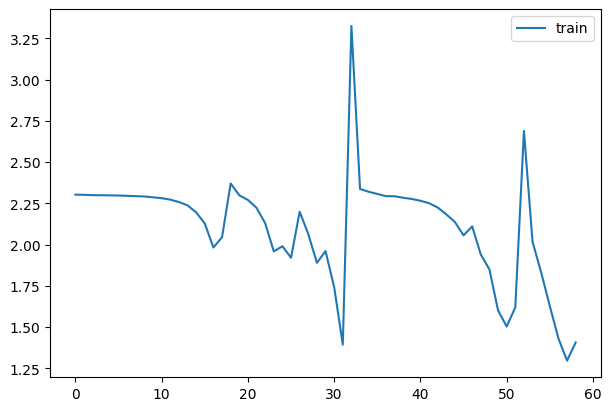

In [39]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, epochs=1, xtra_cbs=[hc]);

The hook values are still stored in the class instance although the actual hooks have been removed

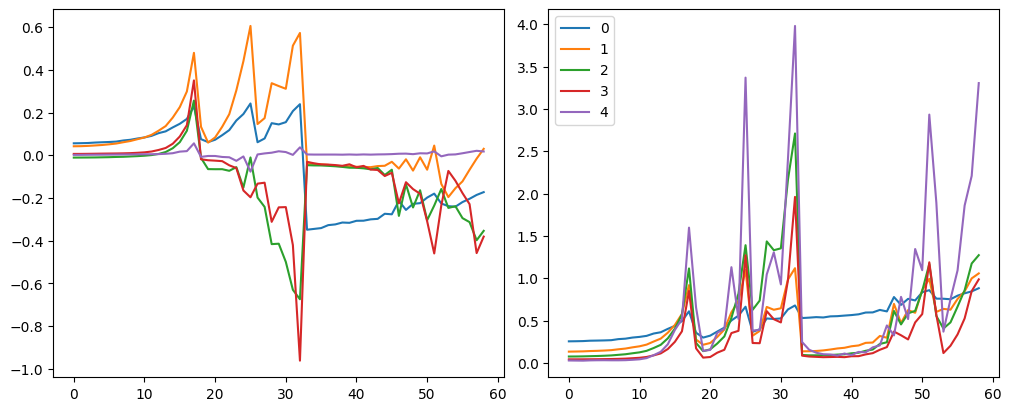

In [40]:
fig,axs = plt.subplots(1,2, figsize=(10,4))
for h in hc:
    for i in 0,1: axs[i].plot(h.stats[i])
plt.legend(range(6));

### Enhanced ways to visulise the activations (Histograms)

By calculating and storing a histogram of the activations for each layer and batch we can get a better visulisation as to how the activations vary

In [41]:
#| export
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40,0,10))

accuracy,loss,epoch,train
0.242,2.111,0,True
0.376,2.125,0,False


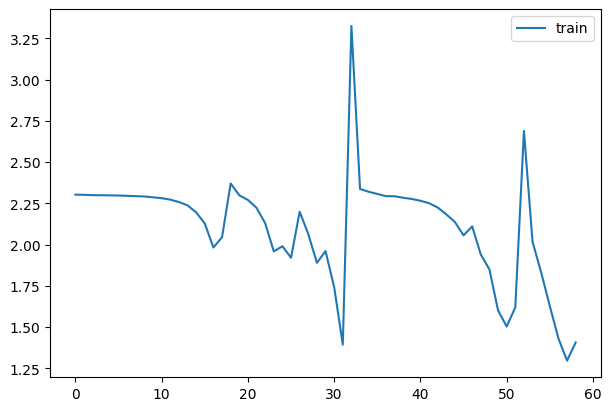

In [42]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
hc = HooksCallback(append_stats, module_filter=fc.risinstance(nn.Conv2d))
fit(model, epochs=1, xtra_cbs=[hc]);

In [43]:
#| export
# Thanks to @ste for initial version of histgram plotting code
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

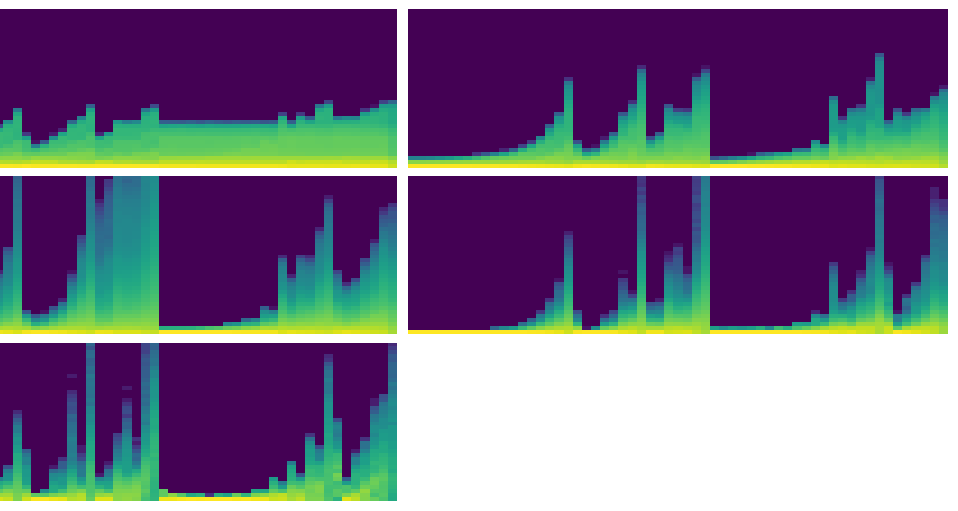

In [45]:
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flat, hc):
    show_image(get_hist(h), ax, origin='lower')

In [46]:
h1 = torch.stack(hc.hooks[0].stats[2]).t().float()

In [47]:
h1.shape, h1[0].shape

(torch.Size([40, 59]), torch.Size([59]))

`h1[0].shape` is the sum of values in the minimum bin for each batch
`h1.sum(0)` is the total number of activations for each batch
Thus the value returned is the proportion of the total activations in the minimum bin

In [48]:
h1.sum(0).shape

torch.Size([59])

In [49]:
h1[0]/h1.sum(0)

tensor([0.76, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.74, 0.74, 0.73, 0.73, 0.73, 0.71, 0.71, 0.70, 0.70, 0.69, 0.66, 0.72, 0.67, 0.67, 0.67,
        0.70, 0.69, 0.68, 0.67, 0.69, 0.68, 0.70, 0.69, 0.69, 0.68, 0.67, 0.59, 0.59, 0.59, 0.58, 0.57, 0.57, 0.56, 0.56, 0.55, 0.55, 0.55,
        0.54, 0.55, 0.52, 0.44, 0.49, 0.47, 0.46, 0.46, 0.45, 0.48, 0.49, 0.49, 0.45, 0.46, 0.44])

In [50]:
#|export
def get_min(h):
    """ Calculate the proportion of activations in the smallest bin
    """
    h_arr = torch.stack(h.stats[2]).t().float()
    return h_arr[0] / h_arr.sum(0)

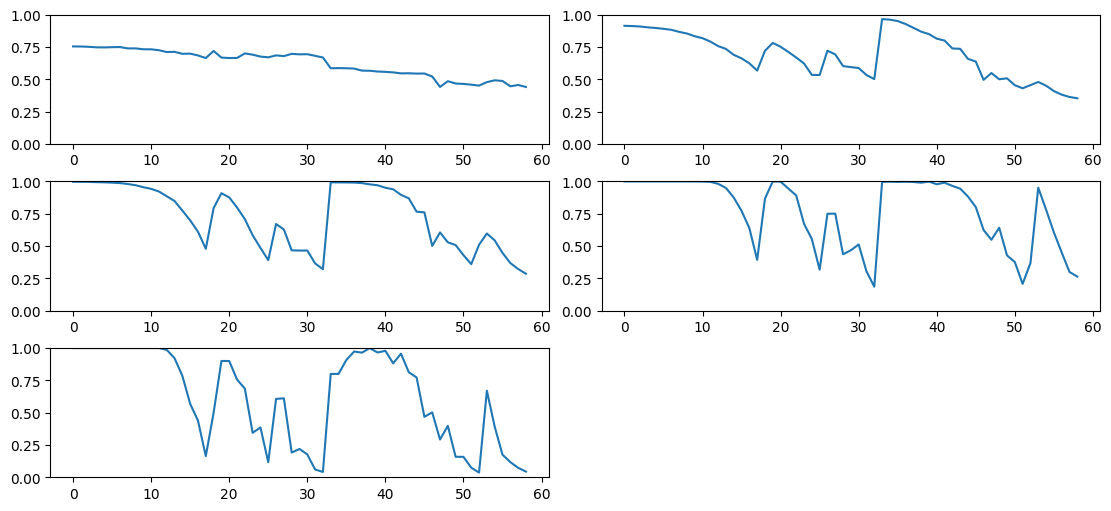

In [51]:
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flatten(), hc):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)

The above plots clearly show that many of the activations are doing nothing for much of the training and are effectively zero

## Activation Stats 

The above plotting routines can be put into a class to make them available for easy plotting after training

In [53]:
#|export
class ActivationStatsCB(HooksCallback):
    """ Note that this builds upon the earlier work.  I have deviated from the course by passing in the 
    hookfunc since I think this gived greater flexibility moving forwards, although so many things are 
    now linked to the structure of the appstats function that it might be better to simply integrate that
    into this class
    """
    def __init__(self, hookfunc, module_filter=fc.noop):
        super().__init__(hookfunc, module_filter)
        
    def color_dim(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')
    
    def dead_chart(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=(11,5))
        for ax,h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)

    def plot_stats(self, figsize=(10,4)):
        fig,axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in 0,1: 
                axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))

In [54]:
astats = ActivationStatsCB(append_stats, fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.242,2.111,0,True
0.376,2.125,0,False


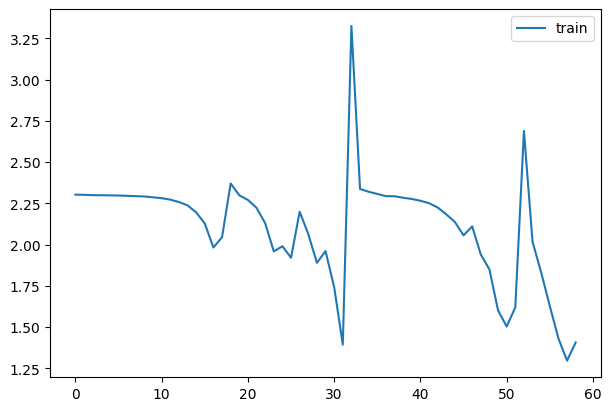

In [55]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, epochs=1, xtra_cbs=[astats]);

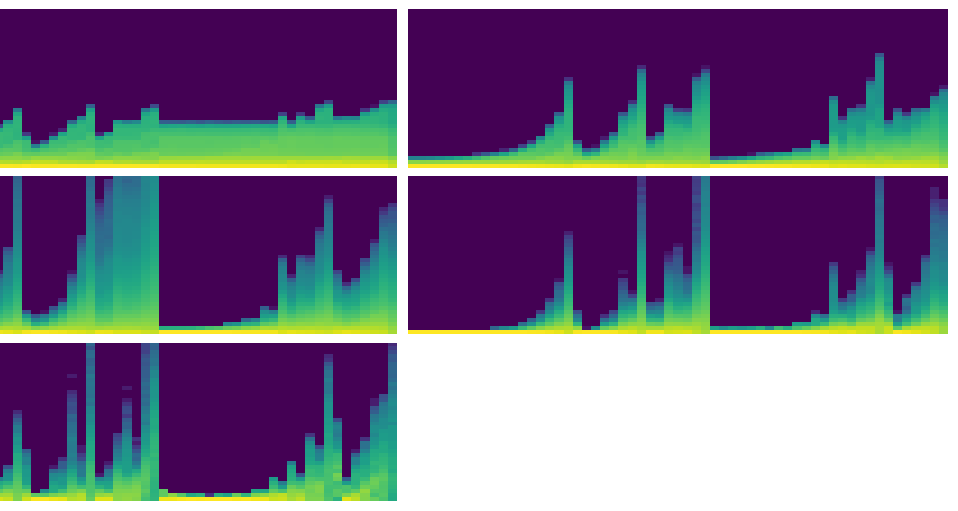

In [56]:
astats.color_dim()

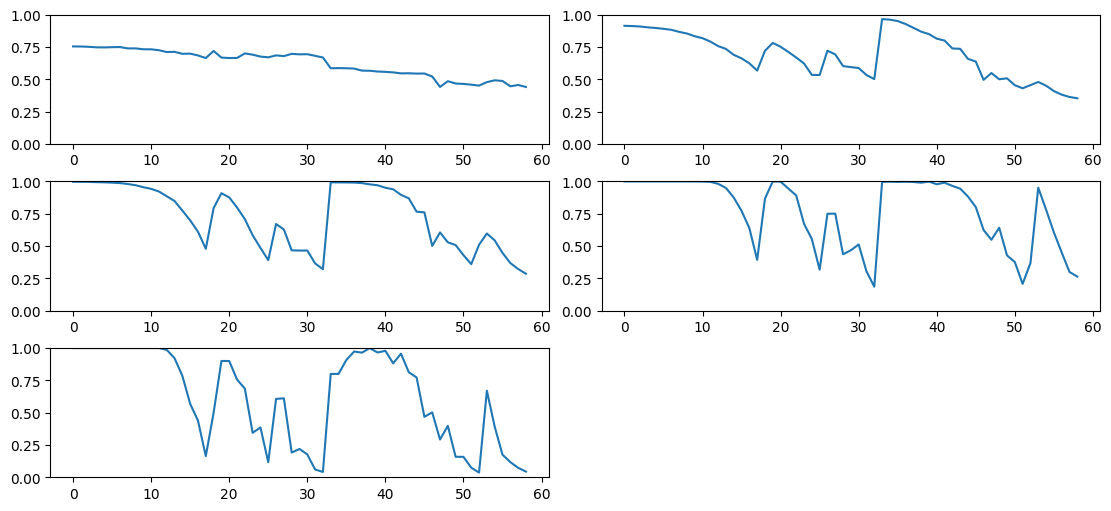

In [57]:
astats.dead_chart()

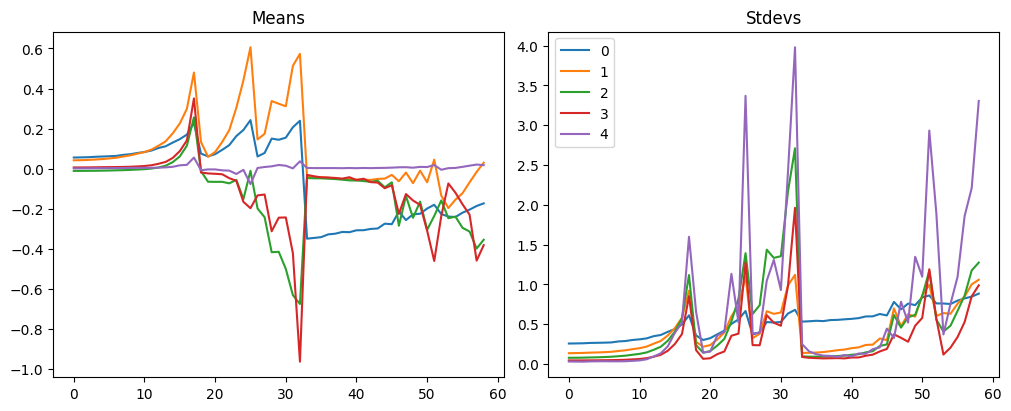

In [58]:
astats.plot_stats()

## Export

In [4]:
import nbdev; nbdev.nbdev_export()